In [ ]:
## ---------------- SEP5 testing gedi extraction code -----------------------

In [ ]:
##
# conda install -c conda-forge r-optmatch
# conda install -c conda-forge r-RItools
##

In [68]:
install.packages("s3")
install.packages("RItools")    

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependency ‘svd’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [3]:
library("terra")
library("dplyr")
library("sf")
#install.packages("s3")
library("s3")

library("sp")
library("foreach")
library("stringr")
library("aws.s3")
#conda install -c conda-forge r-optmatch #r-ggmap r-hrbrthemes r-Hmisc
#library("optmatch")
#install.packages("doParallel")
#library("doParallel")
#install.packages("RItools")    
library("RItools")


terra 1.7.29


Attaching package: ‘dplyr’


The following objects are masked from ‘package:terra’:

    intersect, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Linking to GEOS 3.11.2, GDAL 3.7.0, PROJ 9.2.0; sf_use_s2() is TRUE



ERROR: Error in library("RItools"): there is no package called ‘RItools’


In [4]:
#s3 <- paws::s3()

In [5]:
#To test, we define the variables manually. For final version, run the commented out section below
#iso3 <-"Bpt"
iso3 <-"Bpt"
gediwk <- 24
mproc <- 1

In [6]:
#-------------------------------------------------------------------------------
#args = commandArgs(trailingOnly=TRUE)
#if (length(args)==0) {
#  stop("At least one argument must be supplied (input file).n", call.=FALSE)
#} else if (length(args)>=1) {
#  
#  iso3 <- args[1]  #country to process
#  gediwk <- args[2]   #the # of weeks GEDI data to use
#  mproc <- as.integer(args[3])  #the number of cores to use for matching 
#}
#-------------------------------------------------------------------------------

In [7]:
cat("Step 0: Loading global variables for", iso3,"with wk", gediwk, "data \n")

#f.path <- "/projects/my-public-bucket/GEDI_global_PA_v2/"
f.path <- "s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/"

matching_tifs <- c("wwf_biomes","wwf_ecoreg","lc2000","d2roads", "dcities","dem",
                   "pop_cnt_2000","pop_den_2000","slope", "tt2cities_2000", "wc_prec_1990-1999",
                   "wc_tmax_1990-1999","wc_tavg_1990-1999","wc_tmin_1990-1999" )

ecoreg_key <- read.csv(s3_get(paste(f.path,"wwf_ecoregions_key.csv",sep="")))
#unlink(s3_get(paste(f.path,"wwf_ecoregions_key.csv",sep="")))

allPAs <- readRDS(s3_get(paste(f.path,"WDPA_shapefiles/WDPA_polygons/",iso3,"_PA_poly.rds",sep="")))

MCD12Q1 <- rast(s3_get(paste(f.path,"GEDI_ANCI_PFT_r1000m_EASE2.0_UMD_v1_projection_defined_6933.tif",sep="")))
crs(MCD12Q1)  <- "epsg:6933"

world_region <- rast(s3_get(paste(f.path,"GEDI_ANCI_CONTINENT_r1000m_EASE2.0_UMD_v1_revised_projection_defined_6933.tif",sep="")))
crs(world_region)  <- "epsg:6933"

s3_get_files(c(paste(f.path,"WDPA_countries/shp/",iso3,".shp",sep=""),
              paste(f.path,"WDPA_countries/shp/",iso3,".shx",sep=""),
              paste(f.path,"WDPA_countries/shp/",iso3,".prj",sep=""),
              paste(f.path,"WDPA_countries/shp/",iso3,".dbf",sep="")),confirm = FALSE)
adm <- st_read(s3_get(paste(f.path,"WDPA_countries/shp/",iso3,".shp",sep="")))

#s3_path <- paste("/vsis3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_countries/shp/",iso3,".shp",sep="") #Redo this for the gpkg
#adm <- st_read(s3_path)
adm_prj <- project(vect(adm), "epsg:6933")

load(s3_get(paste(f.path,"rf_noclimate.RData",sep="")))
#source(s3_get(paste(f.path,"matching_func.R",sep="")))
source(s3_get(paste(f.path,"vl_GEDI-PA_2024/matching_func_2024.R",sep="")))

flag <- "run all"
#flag <- "run remaining"

Step 0: Loading global variables for Bpt with wk 24 data 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/wwf_ecoregions_key.csv already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/wwf_ecoregions_key.csv

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_shapefiles/WDPA_polygons/Bpt_PA_poly.rds already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_shapefiles/WDPA_polygons/Bpt_PA_poly.rds

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/GEDI_ANCI_PFT_r1000m_EASE2.0_UMD_v1_projection_defined_6933.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/GEDI_ANCI_PFT_r1000m_EASE2.0_UMD_v1_projection_defined_6933.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/GEDI_ANCI_CONTINENT_r1000m_EASE2.0_UMD_v1_revised_projection_defined_6933.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/GEDI_ANCI_CONTINE

Reading layer `Bpt' from data source 
  `/projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_countries/shp/Bpt.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 7 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -59.18886 ymin: -22.11834 xmax: -54.92231 ymax: -15.52386
Geodetic CRS:  WGS 84


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/rf_noclimate.RData already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/rf_noclimate.RData

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/vl_GEDI-PA_2024/matching_func_2024.R already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/vl_GEDI-PA_2024/matching_func_2024.R



In [8]:
#---------------STEP5. GEDI PROCESSING ---------------- 
#using GEDI shots to extract the treatment/control status, also extract the MODIS PFT for AGB prediction

# if (file.exists(paste(f.path,"WDPA_GEDI_extract/",iso3,"_wk",gediwk,"/",iso3,"_gedi_extracted_matching_wk",gediwk,".RDS", sep=""))){
cat(paste("Step 5: Performing WK ", gediwk, "GEDI extraction for", iso3,"\n"))
#matched_all <-read.csv(paste(f.path,"WDPA_extract4_residual_PAs/", iso3, "_wk_", gediwk, "_null_matches_rerun.csv",sep="")) 
matched_all <- read.csv(s3_get(paste(f.path,"WDPA_matching_results/",iso3,"_wk24_filelist.csv",sep="")))[,2]
matched_all
length(matched_all)   

Step 5: Performing WK  24 GEDI extraction for Bpt 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_matching_results/Bpt_wk24_filelist.csv already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_matching_results/Bpt_wk24_filelist.csv



[1] "Bpt_pa_220297_matching_results_wk24.RDS"   
 [2] "Bpt_pa_2220_matching_results_wk24.RDS"     
 [3] "Bpt_pa_2581_matching_results_wk24.RDS"     
 [4] "Bpt_pa_33968_matching_results_wk24.RDS"    
 [5] "Bpt_pa_33985_matching_results_wk24.RDS"    
 [6] "Bpt_pa_352016_matching_results_wk24.RDS"   
 [7] "Bpt_pa_352021_matching_results_wk24.RDS"   
 [8] "Bpt_pa_352270_matching_results_wk24.RDS"   
 [9] "Bpt_pa_352271_matching_results_wk24.RDS"   
[10] "Bpt_pa_352430_matching_results_wk24.RDS"   
[11] "Bpt_pa_352461_matching_results_wk24.RDS"   
[12] "Bpt_pa_352463_matching_results_wk24.RDS"   
[13] "Bpt_pa_352466_matching_results_wk24.RDS"   
[14] "Bpt_pa_478452_matching_results_wk24.RDS"   
[15] "Bpt_pa_555542500_matching_results_wk24.RDS"
[16] "Bpt_pa_555542528_matching_results_wk24.RDS"
[17] "Bpt_pa_555542552_matching_results_wk24.RDS"
[18] "Bpt_pa_555542777_matching_results_wk24.RDS"
[19] "Bpt_pa_555576153_matching_results_wk24.RDS"
[20] "Bpt_pa_555576191_matching_results_wk24.RDS"
[21] "Bpt_pa_555576276_matching_results_wk24.RDS"
[22] "Bpt_pa_555576295_matching_results_wk24.RDS"
[23] "Bpt_pa_555576310_matching_results_wk24.RDS"
[24] "Bpt_pa_555576396_matching_results_wk24.RDS"
[25] "Bpt_pa_555576444_matching_results_wk24.RDS"
[26] "Bpt_pa_555599959_matching_results_wk24.RDS"
[27] "Bpt_pa_555600164_matching_results_wk24.RDS"
[28] "Bpt_pa_555682279_matching_results_wk24.RDS"
[29] "Bpt_pa_67816_matching_results_wk24.RDS"

[1] 29

In [9]:
f.path <- "/projects/my-public-bucket/GEDI_global_PA_v2/"
#f.path <- "s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/"

matched_PAs <- foreach(this_rds=matched_all, .combine = c, .packages=c('sp','magrittr', 'dplyr','tidyr','terra')) %do% {  #non-NA matched results
  matched_PAs=c()
  print(this_rds)
  if(nchar(iso3)>3){
    id_pa <- basename(this_rds)%>%readr::parse_number() %>% unique()  
  } else {
    id_pa <- basename(this_rds)%>%readr::parse_number() %>% unique()
  }
  matched <- readRDS(paste(f.path,"WDPA_matching_results/",iso3,"_wk",gediwk,"/",iso3,"_pa_",id_pa,"_matching_results_wk",gediwk,".RDS",sep=""))
  if(!is.null(matched)){
    if(nrow(matched)!=0){
      matched_PAs=c(matched_PAs,this_rds) 
    }
  }else {
    # print(this_rds)
    matched_PAs=matched_PAs
  }
  return(matched_PAs)
}
length(matched_PAs)


Attaching package: ‘magrittr’


The following objects are masked from ‘package:terra’:

    extract, inset



Attaching package: ‘tidyr’


The following object is masked from ‘package:magrittr’:

    extract


The following object is masked from ‘package:terra’:

    extract




[1] "Bpt_pa_220297_matching_results_wk24.RDS"
[1] "Bpt_pa_2220_matching_results_wk24.RDS"
[1] "Bpt_pa_2581_matching_results_wk24.RDS"
[1] "Bpt_pa_33968_matching_results_wk24.RDS"
[1] "Bpt_pa_33985_matching_results_wk24.RDS"
[1] "Bpt_pa_352016_matching_results_wk24.RDS"
[1] "Bpt_pa_352021_matching_results_wk24.RDS"
[1] "Bpt_pa_352270_matching_results_wk24.RDS"
[1] "Bpt_pa_352271_matching_results_wk24.RDS"
[1] "Bpt_pa_352430_matching_results_wk24.RDS"
[1] "Bpt_pa_352461_matching_results_wk24.RDS"
[1] "Bpt_pa_352463_matching_results_wk24.RDS"
[1] "Bpt_pa_352466_matching_results_wk24.RDS"
[1] "Bpt_pa_478452_matching_results_wk24.RDS"
[1] "Bpt_pa_555542500_matching_results_wk24.RDS"
[1] "Bpt_pa_555542528_matching_results_wk24.RDS"
[1] "Bpt_pa_555542552_matching_results_wk24.RDS"
[1] "Bpt_pa_555542777_matching_results_wk24.RDS"
[1] "Bpt_pa_555576153_matching_results_wk24.RDS"
[1] "Bpt_pa_555576191_matching_results_wk24.RDS"
[1] "Bpt_pa_555576276_matching_results_wk24.RDS"
[1] "Bpt_pa_5555762

[1] 26

In [10]:
if(flag=="run all"){  #determine how many PAs to run the extraction process
  matched_PAs <- matched_PAs
  cat("Step 5: running extraction on all", length(matched_PAs),"of non-NA matched results in", iso3,"\n")
} else if (flag=="run remaining"){
  pattern1 = c(paste("wk",gediwk,sep=""),"RDS")
  extracted_PAid <- list.files(paste(f.path,"WDPA_GEDI_extract/",iso3,"_wk",gediwk,"/",sep=""), full.names = F, pattern=paste0(pattern1, collapse="|"))%>%
    readr::parse_number() %>% unique()
  matched_PA_id <- matched_PAs %>% readr::parse_number()
  runPA_id <- matched_PA_id[!(matched_PA_id %in% extracted_PAid)]
  if (length(runPA_id)>0){
    Pattern2 <-  paste(runPA_id, collapse="|")
    runPA <-  matched_PAs[grepl(Pattern2,matched_PAs)]
    # runPA_ind <- str_detect(matched_PAs, paste(runPA_id, collapse = "|"))
    matched_PAs <-runPA
  } else {
    matched_PAs <- NULL
    cat("Step 5 already done for", iso3, "\n")
  }
}

Step 5: running extraction on all 26 of non-NA matched results in Bpt 


In [67]:
#f.path <- "s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/"
#source(s3_get(paste(f.path,"vl_GEDI-PA_2024/matching_func_2024.R",sep="")))
f.path <- "/projects/my-public-bucket/GEDI_global_PA_v2/"
source(paste(f.path,"vl_GEDI-PA_2024/matching_func_2024.R",sep=""))

In [68]:
f.path <- "s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/"

this_rds <- matched_PAs[18]
id_pa <- basename(this_rds) %>% readr::parse_number() %>% unique()
print(this_rds)

[1] "Bpt_pa_555576153_matching_results_wk24.RDS"


In [69]:
matched <- readRDS(s3_get(paste(f.path,"WDPA_matching_results/",iso3,"_wk",gediwk,"/",iso3,"_pa_",id_pa,"_matching_results_wk",gediwk,".RDS",sep="")))

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_matching_results/Bpt_wk24/Bpt_pa_555576153_matching_results_wk24.RDS already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_matching_results/Bpt_wk24/Bpt_pa_555576153_matching_results_wk24.RDS



In [70]:
head(matched)
nrow(matched)

lat,lon,UID,status,land_cover,wwfbiom,wwfecoreg,elevation,slope,mean_temp,⋯,min_temp,prec,d2road,d2city,popden,tt2city,popcnt,propensity_score,matched,pa_id
<dbl>,<dbl>,<int>,<lgl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
-18.21290,-56.14627,1,TRUE,l4_wetlands,Flooded Grasslands & Savannas,Pantanal,134,0.00000000,25.52893,⋯,13.63345,4438.776,0.2704162,2.315766,0.01423765,454.5520,0.01163853,0.007222026,l4_wetlands.1,555576153
-18.21290,-56.13589,2,TRUE,l4_wetlands,Flooded Grasslands & Savannas,Pantanal,134,0.07729086,25.52893,⋯,13.63345,4438.776,0.2635230,2.310317,0.01423765,443.7720,0.01163853,0.007058870,l4_wetlands.2,555576153
-18.21290,-56.12552,3,TRUE,l4_wetlands,Flooded Grasslands & Savannas,Pantanal,134,0.12286700,25.51922,⋯,13.60062,4443.585,0.2567153,2.304885,0.01423766,444.8444,0.01163853,0.006965286,l4_wetlands.3,555576153
-18.21290,-56.11515,4,TRUE,l4_wetlands,Flooded Grasslands & Savannas,Pantanal,135,0.12802088,25.49636,⋯,13.52332,4454.910,0.2499999,2.299471,0.01423765,440.0235,0.01163853,0.006880701,l4_wetlands.4,555576153
-18.21290,-56.10477,5,TRUE,l4_wetlands,Flooded Grasslands & Savannas,Pantanal,138,0.05611214,25.49636,⋯,13.52332,4454.910,0.2429562,2.294074,0.01423765,420.4587,0.01163853,0.006799711,l4_wetlands.5,555576153
-18.22115,-56.14627,6,TRUE,l4_wetlands,Flooded Grasslands & Savannas,Pantanal,134,0.04068607,25.52893,⋯,13.63345,4438.776,0.2751261,2.322070,0.01423765,518.8923,0.01163797,0.007508595,l4_wetlands.6,555576153


[1] 176

In [71]:
mras  <- tryCatch(matched2ras(matched),
                      error=function(cond){
                        message(cond)
                        cat("Matched result is likely null for country", iso3,"pa", id_pa, "dimension of the match is", dim(matched),"\n")
                        # writeLines("Matched results is likely null for country", paste(f.path,"WDPA_log/",iso3,"_log_matching.txt", sep=""))
                        return(NULL)}) #convert the macthed df to a raster stack 
print(table(mras$status[]))
mras

Bpt converting the matched csv to a raster stack for extraction

 0  1 
88 88 


class       : SpatRaster 
dimensions  : 488, 244, 7  (nrow, ncol, nlyr)
resolution  : 1000, 1000  (x, y)
extent      : -5558530, -5314530, -2513350, -2025350  (xmin, xmax, ymin, ymax)
coord. ref. : WGS 84 / NSIDC EASE-Grid 2.0 Global (EPSG:6933) 
source(s)   : memory
names       : status,     pa_id, wwfbiom, wwfecoreg,    UID, pft, ... 
min values  :      0, 555576153,       1,         1,      1,   0, ... 
max values  :      1, 555576153,       1,         1, 123578,  11, ... 

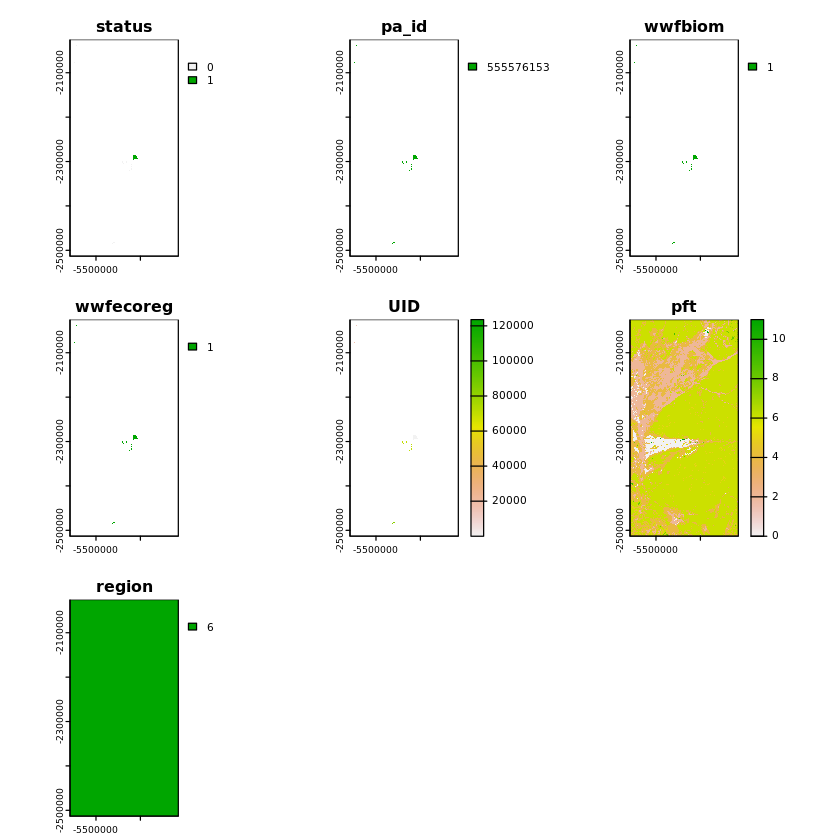

In [72]:
plot(mras)

In [73]:
iso_matched_gedi <- extract_gedi(matched=matched, mras=mras, iso3=iso3)

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/vero_1deg_tileindex/tileindex_Bpt.csv already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/vero_1deg_tileindex/tileindex_Bpt.csv



Reading in no.  1 csv of  29 csvs for iso3 Bpt 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_21707_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_21707_L4A.gpkg



Reading layer `tile_num_21707_L4A' from data source 
  `/projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_21707_L4A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 298827 features and 11 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -59.99999 ymin: -16.99999 xmax: -59 ymax: -16
Geodetic CRS:  WGS 84


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/tile_num_21707_L2A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/tile_num_21707_L2A.gpkg



Reading layer `tile_num_21707_L2A' from data source 
  `/projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/tile_num_21707_L2A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 1021606 features and 17 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -60 ymin: -17 xmax: -59 ymax: -16
Geodetic CRS:  WGS 84
[1] 5777565      22
[1] 5777565
[1]  0 29
Reading in no.  2 csv of  29 csvs for iso3 Bpt 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_21886_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_21886_L4A.gpkg



Reading layer `tile_num_21886_L4A' from data source 
  `/projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_21886_L4A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 574572 features and 11 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -59 ymin: -16 xmax: -58 ymax: -15
Geodetic CRS:  WGS 84
Reading layer `tile_num_21886_L2A' from data source 
  `/projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/tile_num_21886_L2A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 967598 features and 17 fields
Geometry type: POINT
Dimension: 

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_21887_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_21887_L4A.gpkg



Reading layer `tile_num_21887_L4A' from data source 
  `/projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_21887_L4A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 533535 features and 11 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -59 ymin: -17 xmax: -58 ymax: -16
Geodetic CRS:  WGS 84
Reading layer `tile_num_21887_L2A' from data source 
  `/projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/tile_num_21887_L2A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 1018412 features and 17 fields
Geometry type: POINT
Dimension:

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_21888_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_21888_L4A.gpkg



Reading layer `tile_num_21888_L4A' from data source 
  `/projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_21888_L4A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 375667 features and 11 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -59 ymin: -18 xmax: -58 ymax: -17
Geodetic CRS:  WGS 84
Reading layer `tile_num_21888_L2A' from data source 
  `/projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/tile_num_21888_L2A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 1173714 features and 17 fields
Geometry type: POINT
Dimension:

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_21890_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_21890_L4A.gpkg



Reading layer `tile_num_21890_L4A' from data source 
  `/projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_21890_L4A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 406812 features and 11 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -59 ymin: -20 xmax: -58 ymax: -19
Geodetic CRS:  WGS 84
Reading layer `tile_num_21890_L2A' from data source 
  `/projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/tile_num_21890_L2A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 1198119 features and 17 fields
Geometry type: POINT
Dimension:

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_21891_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_21891_L4A.gpkg



Reading layer `tile_num_21891_L4A' from data source 
  `/projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_21891_L4A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 475643 features and 11 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -59 ymin: -21 xmax: -58.00001 ymax: -20
Geodetic CRS:  WGS 84
Reading layer `tile_num_21891_L2A' from data source 
  `/projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/tile_num_21891_L2A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 1114836 features and 17 fields
Geometry type: POINT
Dime

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22066_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22066_L4A.gpkg



Reading layer `tile_num_22066_L4A' from data source 
  `/projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22066_L4A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 569423 features and 11 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -58 ymin: -16 xmax: -57 ymax: -15
Geodetic CRS:  WGS 84
Reading layer `tile_num_22066_L2A' from data source 
  `/projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/tile_num_22066_L2A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 901412 features and 17 fields
Geometry type: POINT
Dimension: 

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22067_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22067_L4A.gpkg



Reading layer `tile_num_22067_L4A' from data source 
  `/projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22067_L4A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 607847 features and 11 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -58 ymin: -17 xmax: -57 ymax: -16
Geodetic CRS:  WGS 84


ERROR: Error in (function (cond) : error in evaluating the argument 'x' in selecting a method for function 'as.data.frame': Cannot open "/projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/tile_num_22067_L2A.gpkg"; The source could be corrupt or not supported. See `st_drivers()` for a list of supported formats.


In [103]:
gedil4_f <- vect(s3_get(paste("s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/", all_gedil2_f[this_csvid], sep = "")))

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/tile_num_22249_L2A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/tile_num_22249_L2A.gpkg



In [98]:
gedil4_f <- vect(s3_get(paste("s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/", all_gedil4_f[this_csvid], sep = "")))

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22249_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22249_L4A.gpkg



In [99]:
gedil4_f

 class       : SpatVector 
 geometry    : points 
 dimensions  : 725452, 11  (geometries, attributes)
 extent      : -57, -56, -19, -18  (xmin, xmax, ymin, ymax)
 source      : tile_num_22249_L4A.gpkg
 coord. ref. : lon/lat WGS 84 (EPSG:4326) 
 names       :        filename geolocation/sensitivity_a2  agbd_t agbd_se
 type        :           <chr>                      <num>   <num>   <num>
 values      : GEDI04_A_20191~                       0.97    0.44   13.12
               GEDI04_A_20191~                     0.9715 -0.2258   13.13
               GEDI04_A_20191~                     0.9825   6.676   13.09
 agbd_t_se shot_number sensitivity lon_lowestmode elev_lowestmode
     <num>       <int>       <num>          <num>           <num>
     3.445   586265356        0.97            -56             141
     3.446   586265353      0.9715            -56             141
     3.441   586265345      0.9883            -56           136.7
 lat_lowestmode  agbd
          <num> <num>
         -18

In [100]:
names(gedil4_f)

[1] "filename"                   "geolocation/sensitivity_a2"
 [3] "agbd_t"                     "agbd_se"                   
 [5] "agbd_t_se"                  "shot_number"               
 [7] "sensitivity"                "lon_lowestmode"            
 [9] "elev_lowestmode"            "lat_lowestmode"            
[11] "agbd"

In [102]:
gedil4_f[, c("shot_number","agbd","agbd_se","agbd_t","agbd_t_se")]

 class       : SpatVector 
 geometry    : points 
 dimensions  : 725452, 5  (geometries, attributes)
 extent      : -57, -56, -19, -18  (xmin, xmax, ymin, ymax)
 source      : tile_num_22249_L4A.gpkg
 coord. ref. : lon/lat WGS 84 (EPSG:4326) 
 names       : shot_number  agbd agbd_se  agbd_t agbd_t_se
 type        :       <int> <num>   <num>   <num>     <num>
 values      :   586265356 0.214   13.12    0.44     3.445
                 586265353     0   13.13 -0.2258     3.446
                 586265345 49.28   13.09   6.676     3.441

In [109]:
gedi_l4_sub <- gedil4_f[, c("shot_number","agbd","agbd_se","agbd_t","agbd_t_se")]

In [110]:
gedi_l4_sub

 class       : SpatVector 
 geometry    : points 
 dimensions  : 725452, 5  (geometries, attributes)
 extent      : -57, -56, -19, -18  (xmin, xmax, ymin, ymax)
 source      : tile_num_22249_L4A.gpkg
 coord. ref. : lon/lat WGS 84 (EPSG:4326) 
 names       : shot_number  agbd agbd_se  agbd_t agbd_t_se
 type        :       <int> <num>   <num>   <num>     <num>
 values      :   586265356 0.214   13.12    0.44     3.445
                 586265353     0   13.13 -0.2258     3.446
                 586265345 49.28   13.09   6.676     3.441

In [111]:
gedil4_f_path <- paste(f.path, "WDPA_gedi_L4A_tiles/", all_gedil4_f[this_csvid], sep = "")
                #gedil4_f <- as.data.frame(st_read(s3_get(gedil4_f_path)))
                #gedil4_f <- as.data.frame(st_read((gedil4_f_path)))
                gedil4_f <- vect(s3_get(gedil4_f_path))
                
                # Read GEDI L2A data
                gedil2_f_path <- paste(f.path, "WDPA_gedi_L2A_tiles/", all_gedil2_f[this_csvid], sep = "")
                #gedil2_f <- as.data.frame(st_read(s3_get(gedil2_f_path)))
                #gedil2_f <- as.data.frame(st_read((gedil2_f_path)))
                gedil2_f <- vect(s3_get(gedil2_f_path))
                
                # Check if GEDI L4A data is empty
                if (nrow(gedil4_f) < 1) {
                    cat("Error: No data for GEDI L4A\n")
                    gedi_l24 <- gedil2_f
                    gedi_l24$agbd <- NA
                    gedi_l24$agbd_se <- NA
                    gedi_l24$agbd_t <- NA
                    gedi_l24$agbd_t_se <- NA
                } else {
                    # Select relevant columns from GEDI L4A
                    #gedi_l4_sub <- gedil4_f %>% dplyr::select(shot_number, agbd, agbd_se, agbd_t, agbd_t_se)
                    gedi_l4_sub <- gedil4_f[, c("shot_number","agbd","agbd_se","agbd_t","agbd_t_se")]
                    
                    # Join with GEDI L2A data
                    gedi_l24 <- merge(gedil2_f, gedi_l4_sub, by = "shot_number")
                }
            

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22249_L4A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_22249_L4A.gpkg

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/tile_num_22249_L2A.gpkg already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/tile_num_22249_L2A.gpkg



In [112]:
gedi_l24

 class       : SpatVector 
 geometry    : points 
 dimensions  : 723295, 21  (geometries, attributes)
 extent      : -57, -56, -19, -18  (xmin, xmax, ymin, ymax)
 coord. ref. : lon/lat WGS 84 (EPSG:4326) 
 names       : shot_number        filename  rh80  rh40  rh25  rh75  rh30  rh70
 type        :       <int>           <chr> <num> <num> <num> <num> <num> <num>
 values      :   586265356 GEDI02_A_20191~  2.09 -0.14 -0.86  1.64 -0.59  1.31
                 586265353 GEDI02_A_20191~  1.34 -0.37 -1.04  1.08 -0.78  0.86
                 586265345 GEDI02_A_20191~  5.42  1.16 -0.41  4.68  0.11     4
  rh98  rh90 (and 11 more)
 <num> <num>              
   5.2  3.25              
   3.4  2.09              
 10.33  7.63              

In [114]:
gedi_l24_sp <- gedi_l24
gedi_l24_sp <- project(gedi_l24_sp, "epsg:6933")                

In [115]:
gedi_l24_sp

 class       : SpatVector 
 geometry    : points 
 dimensions  : 723295, 21  (geometries, attributes)
 extent      : -5499718, -5403232, -2380838, -2259695  (xmin, xmax, ymin, ymax)
 coord. ref. : WGS 84 / NSIDC EASE-Grid 2.0 Global (EPSG:6933) 
 names       : shot_number        filename  rh80  rh40  rh25  rh75  rh30  rh70
 type        :       <int>           <chr> <num> <num> <num> <num> <num> <num>
 values      :   586265356 GEDI02_A_20191~  2.09 -0.14 -0.86  1.64 -0.59  1.31
                 586265353 GEDI02_A_20191~  1.34 -0.37 -1.04  1.08 -0.78  0.86
                 586265345 GEDI02_A_20191~  5.42  1.16 -0.41  4.68  0.11     4
  rh98  rh90 (and 11 more)
 <num> <num>              
   5.2  3.25              
   3.4  2.09              
 10.33  7.63              

In [117]:
iso_matched_gedi_df <- NULL 

In [118]:
matched_gedi <- terra::extract(mras, gedi_l24_sp, df=TRUE)
                matched_gedi_metrics <- cbind(matched_gedi, gedi_l24_sp)
                matched_gedi_metrics_filtered <- matched_gedi_metrics %>% dplyr::filter(!is.na(status)) %>%
                                                    convertFactor(matched0 = matched,exgedi = .) 

            iso_matched_gedi_df <- rbind(matched_gedi_metrics_filtered, iso_matched_gedi_df)
            print(dim(iso_matched_gedi_df))

[1] 7073   30


In [119]:
iso_matched_gedi_df

ID,status,pa_id,wwfbiom,wwfecoreg,UID,pft,region,shot_number,filename,⋯,lat_lowestmode,rh10,lon_lowestmode,rh60,rh20,agbd,agbd_se,agbd_t,agbd_t_se,stratum
<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<int>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2452,1,555576153,Flooded Grasslands & Savannas,Pantanal,60,DBT,SA,1722349412,GEDI02_A_2019141083048_O02477_04_T00281_02_003_01_V002.h5,⋯,-18.26763,-1.46,-56.01351,3.33,-0.56,5.79434776,13.10631,2.2893772,3.443145,DBT_SA
2453,1,555576153,Flooded Grasslands & Savannas,Pantanal,60,DBT,SA,1722349411,GEDI02_A_2019141083048_O02477_04_T00281_02_003_01_V002.h5,⋯,-18.26722,-2.35,-56.01384,0.22,-1.53,0.00000000,13.12777,-0.4535378,3.445962,DBT_SA
2454,1,555576153,Flooded Grasslands & Savannas,Pantanal,60,DBT,SA,1722349409,GEDI02_A_2019141083048_O02477_04_T00281_02_003_01_V002.h5,⋯,-18.26640,-2.09,-56.01451,0.26,-1.38,0.00000000,13.12819,-0.4699277,3.446018,DBT_SA
2455,1,555576153,Flooded Grasslands & Savannas,Pantanal,60,DBT,SA,1722349406,GEDI02_A_2019141083048_O02477_04_T00281_02_003_01_V002.h5,⋯,-18.26518,-1.68,-56.01552,4.45,-0.33,8.69748020,13.10720,2.8048639,3.443262,DBT_SA
2456,1,555576153,Flooded Grasslands & Savannas,Pantanal,60,DBT,SA,1722349404,GEDI02_A_2019141083048_O02477_04_T00281_02_003_01_V002.h5,⋯,-18.26436,-2.09,-56.01619,0.18,-1.38,0.00000000,13.12955,-0.5789179,3.446197,DBT_SA
2457,1,555576153,Flooded Grasslands & Savannas,Pantanal,60,DBT,SA,1722349399,GEDI02_A_2019141083048_O02477_04_T00281_02_003_01_V002.h5,⋯,-18.26232,-2.32,-56.01785,0.41,-1.49,0.00000000,13.12428,-0.1471569,3.445504,DBT_SA
2458,1,555576153,Flooded Grasslands & Savannas,Pantanal,60,DBT,SA,1722349398,GEDI02_A_2019141083048_O02477_04_T00281_02_003_01_V002.h5,⋯,-18.26192,-2.47,-56.01819,0.18,-1.61,0.00000000,13.12745,-0.4669918,3.445921,DBT_SA
2459,1,555576153,Flooded Grasslands & Savannas,Pantanal,60,DBT,SA,1722349397,GEDI02_A_2019141083048_O02477_04_T00281_02_003_01_V002.h5,⋯,-18.26151,-2.62,-56.01852,0.22,-1.72,0.00000000,13.12536,-0.2956575,3.445647,DBT_SA
2460,1,555576153,Flooded Grasslands & Savannas,Pantanal,60,DBT,SA,1722349396,GEDI02_A_2019141083048_O02477_04_T00281_02_003_01_V002.h5,⋯,-18.26110,-2.28,-56.01885,0.22,-1.49,0.00000000,13.12745,-0.4304667,3.445920,DBT_SA


In [48]:
#f.path <- "/projects/my-public-bucket/GEDI_global_PA_v2/"
f.path <- "s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/"

this_rds <- matched_PAs[2]
id_pa <- basename(this_rds) %>% readr::parse_number() %>% unique()
    
    #matched <- readRDS(paste(f.path,"WDPA_matching_results/",iso3,"_wk",gediwk,"/",iso3,"_pa_",id_pa,"_matching_results_wk",gediwk,".RDS",sep=""))
    matched <- readRDS(s3_get(paste(f.path,"WDPA_matching_results/",iso3,"_wk",gediwk,"/",iso3,"_pa_",id_pa,"_matching_results_wk",gediwk,".RDS",sep="")))
  
    if (is.null(matched)==TRUE  | nrow(matched)==0) {
        cat("Matched result is null for PA", id_pa, "quitting...\n")
        next  # Skip to the next iteration
    } else if (!is.null(matched)==TRUE){
    mras  <- tryCatch(matched2ras(matched),
                      error=function(cond){
                        message(cond)
                        cat("Matched result is likely null for country", iso3,"pa", id_pa, "dimension of the match is", dim(matched),"\n")
                        # writeLines("Matched results is likely null for country", paste(f.path,"WDPA_log/",iso3,"_log_matching.txt", sep=""))
                        return(NULL)}) #convert the macthed df to a raster stack 
    print(table(mras$status[]))
    if(table(mras$status[])[2]==0 | table(mras$status[])[1]==0 | is.null(mras)){
      cat("Rasterized results unbalanced for PA", id_pa, "quitting...\n")
      next  # Skip to the next iteration
    } else {
        
      startTime <- Sys.time()
        
      iso_matched_gedi <- extract_gedi(matched=matched, mras=mras, iso3=iso3)#}  #run filtered csvs on mras for extarction
        
        if (is.null(iso_matched_gedi)) {
        cat("Matched result is null for PA", id_pa, "quitting...\n")
        next  # Skip to the next iteration
        }

      tElapsed <- Sys.time()-startTime
      cat(tElapsed, "for extracting all PAs in", iso3,"\n")
      cat("Done GEDI for no. ",grep(unique(matched$pa_id), matched_PAs),"pa out of", length(matched_PAs),"\n")

      iso_matched_gedi <-  iso_matched_gedi %>%
            dplyr::select("pa_id","status",
                      "wwfbiom","wwfecoreg","shot_number","lon_lowestmode", 
                      "lat_lowestmode", "lon_lowestmode", 
                      "lat_lowestmode","rh25", "rh50", "rh75","rh90", "rh98")  #write to individual country folder
        
      if (length(unique(iso_matched_gedi$wwfbiom)) >1){
#       pabiome <- iso_matched_gedi$wwfbiom %>% unique() %>% gsub("\b(\pL)\pL{2,}|.","\U\1",.,perl = TRUE)%>% str_c( collapse = "+")
#       pabiome <- iso_matched_gedi$wwfbiom %>% unique() %>% str_replace_all("\\b(\\p{L})\\p{L}{2,}|.", "\\U\\1", perl = TRUE) %>% str_c(collapse = "+")
        pabiome <- iso_matched_gedi$wwfbiom %>% unique() %>% str_replace_all("\\b(\\p{L})\\p{L}{2,}|.", "\\U\\1") %>% str_c(collapse = "+")
      } else if (length(unique(iso_matched_gedi$wwfbiom))==1){
#       pabiome <- iso_matched_gedi$wwfbiom %>% unique() %>% str_replace_all("\\b(\\p{L})\\p{L}{2,}|.", "\\U\\1", perl = TRUE)
        pabiome <- iso_matched_gedi$wwfbiom %>% unique() %>% str_replace_all("\\b(\\p{L})\\p{L}{2,}|.", "\\U\\1")
      } else {
        pabiome <- iso_matched_gedi$wwfbiom %>% unique() }
        continent <- unique(iso_matched_gedi$region) %>% getmode()
      print(paste('output df',dim(iso_matched_gedi)))

      #dir.create(file.path(paste("output/WDPA_GEDI_extract/",sep="")),recursive=TRUE)
      #saveRDS(iso_matched_gedi, file=paste("output/WDPA_GEDI_extract/",iso3,"_pa_", id_pa,"_gedi_wk_",gediwk,"_conti_","biome_",pabiome,".RDS", sep=""))
      #write.csv(iso_matched_gedi, file=paste("output/WDPA_GEDI_extract/",iso3,"_pa_", id_pa,"_iso_matched_gedi_sub_wk_",gediwk,".csv", sep=""))
      dir.create(file.path(paste("/projects/my-public-bucket/GEDI_global_PA_v2/WDPA_GEDI_extract/",sep="")),recursive=TRUE)
      saveRDS(iso_matched_gedi, file=paste("/projects/my-public-bucket/GEDI_global_PA_v2/WDPA_GEDI_extract/",iso3,"_pa_", id_pa,"_gedi_wk_",gediwk,"_conti_","biome_",pabiome,".RDS", sep=""))
      write.csv(iso_matched_gedi, file=paste("/projects/my-public-bucket/GEDI_global_PA_v2/WDPA_GEDI_extract/",iso3,"_pa_", id_pa,"_iso_matched_gedi_sub_wk_",gediwk,".csv", sep=""))
      cat(id_pa,"in",iso3,"result is written to dir\n")
    }
}


Bpp converting the matched csv to a raster stack for extraction

 0  1 
34 34 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/vero_1deg_tileindex/tileindex_Bpp.csv already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/vero_1deg_tileindex/tileindex_Bpp.csv



In [ ]:
print("extracting done")

In [ ]:
allOut <- read.csv("~/GEDI_PA/vl_GEDI-PA_2024/GNB_pa.csv")

In [ ]:
data_sf <- st_as_sf(allOut, coords = c("lon", "lat"), crs = 4326)


In [ ]:
results <- s3$list_objects_v2(Bucket = "maap-ops-workspace", 
                            Prefix=paste("shared/abarenblitt/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/",sep=""))
    all_gedil2_f <- sapply(results$Contents, function(x) {x$Key})
    pattern=paste(".gpkg",sep="")
    all_gedil2_f <- grep(pattern, all_gedil2_f, value=TRUE)
    all_gedil2_f <- basename(all_gedil2_f)[4:5] #Currently specifying working files
    
    results4 <- s3$list_objects_v2(Bucket = "maap-ops-workspace", 
                                Prefix=paste("shared/abarenblitt/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/",sep=""))
    all_gedil4_f <- sapply(results4$Contents, function(x) {x$Key})
    pattern4=paste(".gpkg",sep="")
    all_gedil4_f <- grep(pattern4, all_gedil4_f, value=TRUE)
    all_gedil4_f <- basename(all_gedil4_f)[4:5] #Currently specifying working files


In [ ]:
all_gedil2_f

In [ ]:
gedil4_f <- as.data.frame(st_read(paste(gedipath,"WDPA_gedi_L4A_tiles/",all_gedil4_f[this_csvid],sep="")))

In [ ]:
gedil2_f <- as.data.frame(st_read(paste(gedipath,"WDPA_gedi_L2A_tiles/",all_gedil2_f[this_csvid],sep="")))

In [ ]:
results <- s3$list_objects_v2(Bucket = "maap-ops-workspace", 
                            Prefix=paste("shared/abarenblitt/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/",sep=""))
    all_gedil2_f <- sapply(results$Contents, function(x) {x$Key})
    pattern=paste(".gpkg",sep="")
    all_gedil2_f <- grep(pattern, all_gedil2_f, value=TRUE)
    all_gedil2_f <- basename(all_gedil2_f)[4:5]

all_gedil2_f

In [ ]:
extract_gedi <- function(matched, mras){
    results <- s3$list_objects_v2(Bucket = "maap-ops-workspace", 
                            Prefix=paste("shared/abarenblitt/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/",sep=""))
    all_gedil2_f <- sapply(results$Contents, function(x) {x$Key})
    pattern=paste(".gpkg",sep="")
    all_gedil2_f <- grep(pattern, all_gedil2_f, value=TRUE)
    all_gedil2_f <- basename(all_gedil2_f)[4:5] #Currently specifying working files
    
    results4 <- s3$list_objects_v2(Bucket = "maap-ops-workspace", 
                                Prefix=paste("shared/abarenblitt/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/",sep=""))
    all_gedil4_f <- sapply(results4$Contents, function(x) {x$Key})
    pattern4=paste(".gpkg",sep="")
    all_gedil4_f <- grep(pattern4, all_gedil4_f, value=TRUE)
    all_gedil4_f <- basename(all_gedil4_f)[4:5] #Currently specifying working files
  
    # Initialize an empty list to store results
    results_list <- list()
    iso_matched_gedi_df <- NULL # Initialize before loop

            # Iterate over the sequence of indices for your files
    for (this_csvid in seq_along(all_gedil2_f)) {
                cat("Reading in no. ", this_csvid, "csv of ", length(all_gedil2_f), "csvs for iso3", iso3, "\n")
                
                # Read GEDI L4A data
                gedil4_f_path <- paste(gedipath, "WDPA_gedi_L4A_tiles/", all_gedil4_f[this_csvid], sep = "")
                gedil4_f <- as.data.frame(st_read(gedil4_f_path))
                
                # Read GEDI L2A data
                gedil2_f_path <- paste(gedipath, "WDPA_gedi_L2A_tiles/", all_gedil2_f[this_csvid], sep = "")
                gedil2_f <- as.data.frame(st_read(gedil2_f_path))
            
                # Check if GEDI L4A data is empty
                if (nrow(gedil4_f) < 1) {
                    cat("Error: No data for GEDI L4A\n")
                    gedi_l24 <- gedil2_f
                    gedi_l24
agbd_se <- NA
                    gedi_l24
agbd_t_se <- NA
                } else {
                    # Select relevant columns from GEDI L4A
                    gedi_l4_sub <- gedil4_f %>%
                        dplyr::select(shot_number, agbd, agbd_se, agbd_t, agbd_t_se)
                    
                    # Join with GEDI L2A data
                    gedi_l24 <- inner_join(gedil2_f, gedi_l4_sub, by = "shot_number")
                }
            
                print(dim(gedi_l24))
            
                # Initialize empty spatial object for the current iteration
                gedi_l24_sp <- NULL
            
                # Convert to spatial points data frame if there is data
                if (nrow(gedi_l24) > 0) {
                    gedi_l24_sp <- SpatialPointsDataFrame(
                        coords = gedi_l24[, c("lon_lowestmode", "lat_lowestmode")],
                        data = gedi_l24,
                        proj4string = CRS("+init=epsg:4326")
                    ) %>% spTransform(CRS("+init=epsg:6933"))
                matched_gedi <- terra::extract(mras,vect(gedi_l24_sp), df=TRUE)
                matched_gedi_metrics <- cbind(matched_gedi,gedi_l24_sp@data)
                matched_gedi_metrics_filtered <- matched_gedi_metrics %>% dplyr::filter(!is.na(status)) %>% 
                convertFactor(matched0 = matched,exgedi = .) 

            iso_matched_gedi_df <- rbind(matched_gedi_metrics_filtered,iso_matched_gedi_df)
            print(dim(iso_matched_gedi_df))
         }
        
        # Store results in a list
        results_list[[this_csvid]] <- iso_matched_gedi_df
    }
    
    # Combine all results
    if (!is.null(iso_matched_gedi_df)) {
        iso_matched_gedi_df <- do.call(rbind, results_list)
    }
    
    cat("Done GEDI processing\n")
    return(iso_matched_gedi_df)
}
     

In [ ]:
ex_out <- for (this_csvid in seq_along(length(all_gedil2_f))) {
        ##add the GEDI l4a model prediction for AGB here :
        cat("Readng in no. ", this_csvid,"csv of ", length(all_gedil2_f),"csvs for iso3",iso3,"\n")

    # for (this_gedi4 in all_gedil4_f[this_csvid]){
            gedil4_f <- as.data.frame(st_read(paste(gedipath,"WDPA_gedi_L4A_tiles/",all_gedil4_f[this_csvid],sep="")))
    # }
    # for (this_gedi2 in all_gedil2_f[this_csvid]){
            gedil2_f <- as.data.frame(st_read(paste(gedipath,"WDPA_gedi_L2A_tiles/",all_gedil2_f[this_csvid],sep="")))
    # }
            if (nrow(gedil4_f) < 1){   #is.na(gedi_l4) || 
              cat("error")
              gedi_l24 <- gedil2_f
              gedi_l24
agbd_se <- NA
              gedi_l24
agbd_t_se <- NA
            } else {
              gedi_l4_sub <- gedil4_f %>%
                dplyr::select(shot_number, agbd, agbd_se, agbd_t, agbd_t_se)
              gedi_l24 <- inner_join(gedil2_f, gedi_l4_sub, by="shot_number")

            }

        print(dim(gedi_l24))
        iso_matched_gedi_df <- data.frame()
        if(nrow(gedi_l24)>0){
            gedi_l24_sp <- gedi_l24 %>% 
                SpatialPointsDataFrame(coords=.[,c("lon_lowestmode","lat_lowestmode")],
                                     proj4string=CRS("+init=epsg:4326"), data=.) %>%spTransform(., CRS("+init=epsg:6933"))
        }
        return(gedi_l24_sp)
}
     

In [ ]:
results_list <- list()

# Iterate over the sequence of indices for your files
for (this_csvid in seq_along(all_gedil2_f)) {
    cat("Reading in no. ", this_csvid, "csv of ", length(all_gedil2_f), "csvs for iso3", iso3, "\n")
    
    # Read GEDI L4A data
    gedil4_f_path <- paste(gedipath, "WDPA_gedi_L4A_tiles/", all_gedil4_f[this_csvid], sep = "")
    gedil4_f <- as.data.frame(st_read(gedil4_f_path))
    
    # Read GEDI L2A data
    gedil2_f_path <- paste(gedipath, "WDPA_gedi_L2A_tiles/", all_gedil2_f[this_csvid], sep = "")
    gedil2_f <- as.data.frame(st_read(gedil2_f_path))

    # Check if GEDI L4A data is empty
    if (nrow(gedil4_f) < 1) {
        cat("Error: No data for GEDI L4A\n")
        gedi_l24 <- gedil4_f
        gedi_l24
agbd_se <- NA
        gedi_l24
agbd_t_se <- NA
    } else {
        # Select relevant columns from GEDI L4A
        gedi_l4_sub <- gedil4_f %>%
            dplyr::select(shot_number, agbd, agbd_se, agbd_t, agbd_t_se)
        
        # Join with GEDI L2A data
        gedi_l24 <- inner_join(gedil2_f, gedi_l4_sub, by = "shot_number")
    }

    print(dim(gedi_l24))

    # Initialize empty spatial object for the current iteration
    gedi_l24_sp <- NULL

    # Convert to spatial points data frame if there is data
    if (nrow(gedi_l24) > 0) {
        gedi_l24_sp <- SpatialPointsDataFrame(
            coords = gedi_l24[, c("lon_lowestmode", "lat_lowestmode")],
            data = gedi_l24,
            proj4string = CRS("+init=epsg:4326")
        ) %>% spTransform(CRS("+init=epsg:6933"))
    }
    
    # Store result in the list
    results_list[[this_csvid]] <- gedi_l24_sp
}

In [ ]:
single_result <- results_list[[2]]


In [ ]:
single_result_sf <- st_as_sf(single_result)


In [ ]:
matched<-readRDS("~/output/WDPA_matching_results/GNB_wk24/GNB_pa_351088_matching_results_wk24.RDS")


In [ ]:
ggplot(data_sf) +
  geom_sf(aes(color = status), size = 1) + 
  geom_sf(data = single_result_sf, color = "black", linetype = "dashed") +
  theme_minimal() +
  scale_color_manual(values = c("TRUE" = "purple", "FALSE" = "blue"))+
  labs(title = "Spatial Points from CSV",
       x = "Longitude",
       y = "Latitude",
      color = "Status")
     


In [ ]:
all_gedil2_f


In [ ]:
gediGrid<-st_read("~/my-public-bucket/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/tile_num_29599_L2A.gpkg")
